<div style="font-family: Calibri; background-color: #ccd5ae; padding: 10px 10px;">
    <h1>Decision Tree - plain vanila</h1>
    <h4><u>1. Determine parameters to use</u></h4>
    <p>
        This Notebook is to determine the which patameters to consider in Decision Tree and in what range, this will eb very useful when we fo GridSearchCV if we have narrowed down the Parameters.
    </p>
    <h4><u>2. GridSearch using class_weight and parameters shortlised from Step 1.</u></h4>
<hr>
<h5><b><u>Key Considerations for Decision Tree</u></b></h5>
<p>    
    1. Decision trees are inherently non-linear and can capture complex interactions without the need for explicit polynomial feature expansion. 
    2. Tree-based models naturally perform feature selection by choosing splits based on impurity reduction, so additional filtering with `SelectFromModel` is typically unnecessary.
    3. We do not need to normalize data before using it with a decision tree algorithm because the relative magnitude of features does not affect how they are used for splitting data.
</p>    
</div>

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scripts.plot_tetha import plot_model
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score

In [2]:
%load_ext autoreload
%autoreload 2
from scripts.scores import calc_predict_proba, calc_scores, confusion_matrix_display
from scripts.decision_tree import determine_parameter

In [3]:
warnings.filterwarnings("ignore") 
set_config(display='diagram')
pd.options.display.precision=3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>1. Loading Train and Test dataset</h2>
    <p>Train-Test split is not required, as both dataset provided are separate.</p>
</div>

In [4]:
df = pd.read_csv("data/train.csv" )
df.shape

(255347, 18)

In [5]:
X_train = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_train = df['Default']
print(X_train.shape)
print(y_train.shape)

(255347, 14)
(255347,)


In [6]:
df_test = pd.read_csv("data/test.csv")
df_predictions = pd.read_csv("data/prediction_submission.csv")
df_test = pd.merge(left=df_test,right=df_predictions, left_on='LoanID',right_on='LoanID')
df_test.shape

(109435, 18)

In [7]:
y_test =  df_test['predicted_probability']
X_test = df_test.drop(columns=['LoanID', 'DTIRatio', 'CreditScore', 'predicted_probability'])
print(X_test.shape)
print(y_test.shape)

(109435, 14)
(109435,)


In [8]:
(df_test['predicted_probability']!= df_predictions['predicted_probability']).sum()

0

<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>2. Column Transformation</h2>
</div>

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Univariate Analysis - Conclusion (Recap)</h3>    
    <ul>
            <li>HasCoSigner, HasDependents, HasMortgage are binary fields</li>
            <li>Education, EmploymentType, LoanPurpose, MaritalStatus are categorical data</li>
    </ul>        
    <h4>Transformation is done external to pipeline to avoid the redundent step In GridSearchCV
    </h4>
</div>

In [10]:
transformer = ColumnTransformer(
    [
        ('Binary', OneHotEncoder(drop='if_binary'), ['HasCoSigner', 'HasDependents', 'HasMortgage']),
        ('multi_category', OneHotEncoder(),  ['Education', 'EmploymentType', 'MaritalStatus']),
        ('Loan_category', OneHotEncoder(categories = [['Business', 'Home']], handle_unknown='ignore'), ['LoanPurpose']),    
        # ('Poly', PolynomialFeatures(3, include_bias=True), ['Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'NumCreditLines','InterestRate', 'LoanTerm'])
    ], remainder='passthrough'
        
    # ], remainder='passthrough'
)

In [11]:
X_train = transformer.fit_transform(X_train)

In [12]:
X_test = transformer.transform(X_test)

<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>3. DecisionTree - vanila</h2>
</div>

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
tree = DecisionTreeClassifier(random_state = 42, class_weight={0:1, 1:9})

In [15]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 9}, random_state=42)

In [16]:
depth_1 = tree.get_depth()
n_leaves = tree.get_n_leaves()
train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)

print(f'{"Training Accuracy:":<20}{train_acc:.2f}')
print(f'{"Test Accuracy:":<20}{test_acc:.2f}')
print(f'{"Depth of tree:":<20}{depth_1}')
print(f'{"No. of Leaves:":<20}{n_leaves}')

y_test_pred = tree.predict(X_test)
print(f'{"Recall Score:":<20}{recall_score(y_test, y_test_pred, pos_label=1)}')
print(f'{"Precision Score:":<20}{precision_score(y_test, y_test_pred, pos_label=1)}')
print(f'{"RoC AuC Score:":<20}{roc_auc_score(y_test, y_test_pred)}')
f1 = f1_score(y_test, y_test_pred, pos_label=1)
print(f'{"F1 Score:":<20}{f1:.2}')


Training Accuracy:  1.00
Test Accuracy:      0.80
Depth of tree:      43
No. of Leaves:      33857
Recall Score:       0.10633071864353062
Precision Score:    0.11028022023173638
RoC AuC Score:      0.49724885964196697
F1 Score:           0.11


<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>4. Determine The Decision Tree Parameters</h2>
</div>

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>1. max_depth</h4>    
    <ul>
            <li>Purpose: Limits the depth (number of levels) of the tree.</li>
            <li>Tip: A very deep tree can overfit; setting a maximum depth helps control model complexity.</li>
    </ul>        
</div>

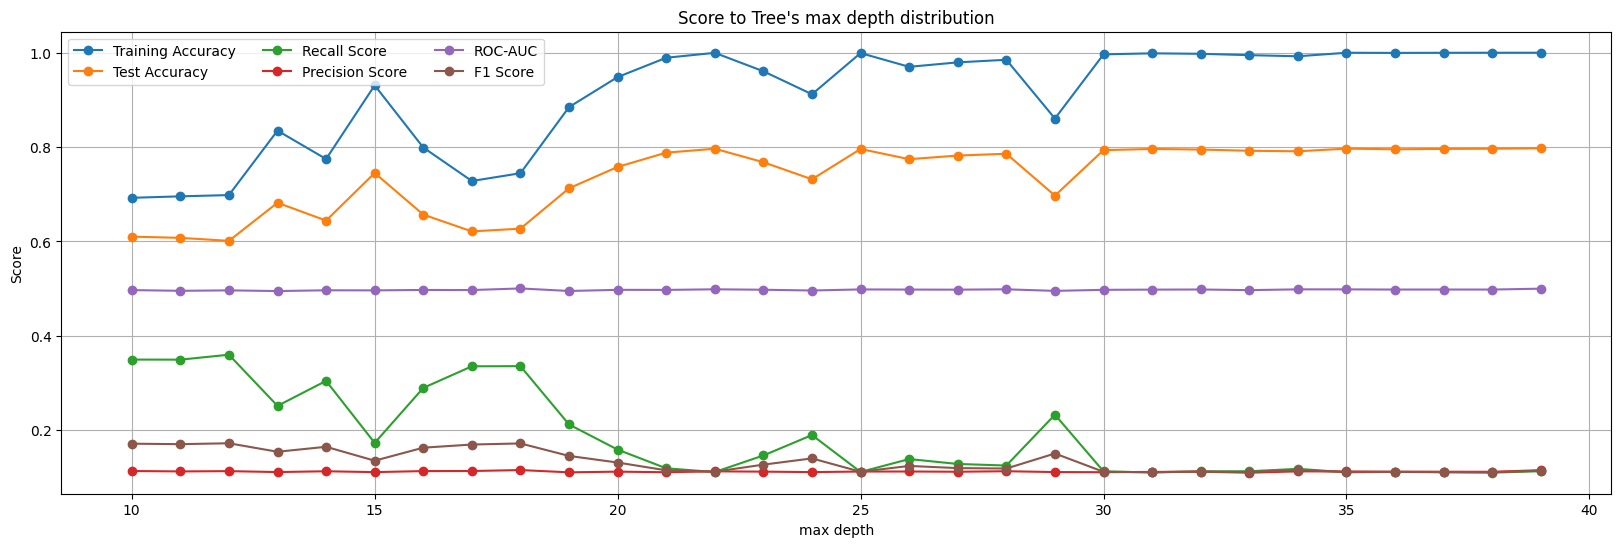

In [17]:
# determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"max_depth", range(10,30))
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"max_depth", range(10,40))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>2. min_samples_split</h4>    
    <ul>
        <li>Purpose: The minimum number of samples required to split an internal node.</li>
        <li>Tip: Increasing this value can make the tree more general and reduce overfitting.</li>
    </ul>        
</div>

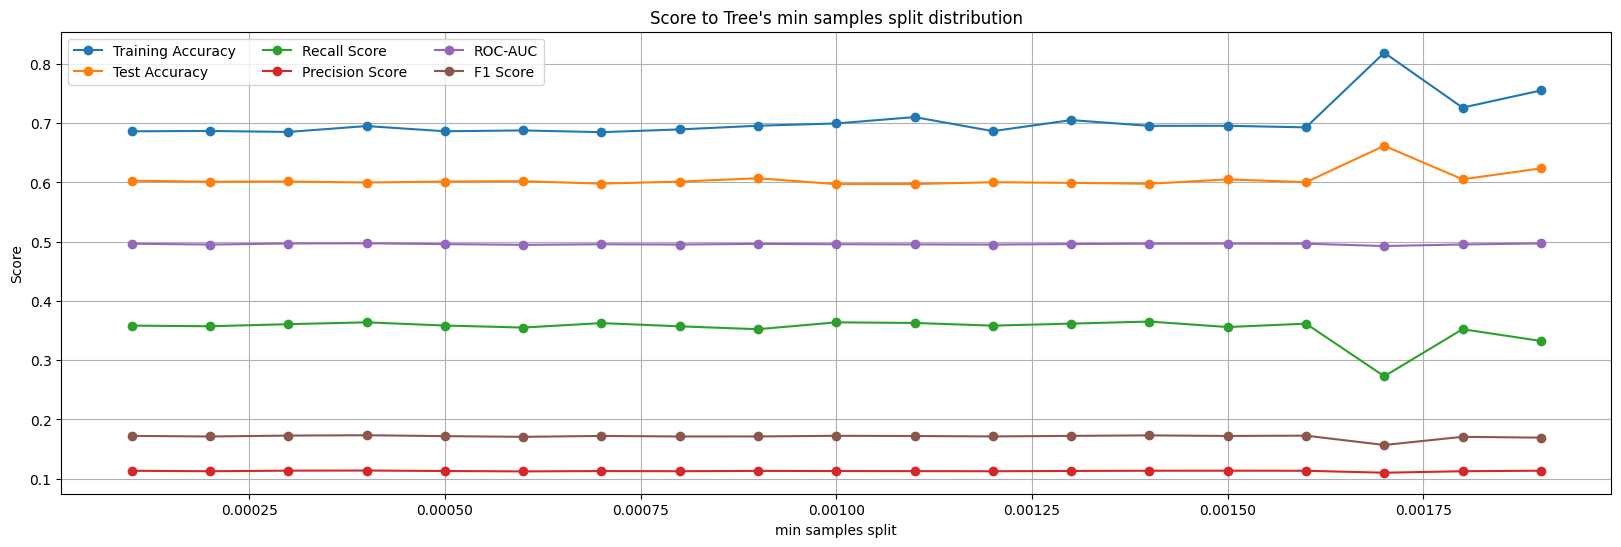

In [18]:
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"min_samples_split", np.arange(0.0001,0.002,0.0001))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>3. min_samples_leaf</h4>    
    <ul>
        <li>Purpose: The minimum number of samples required to be at a leaf node.</li>
        <li>Tip: Larger values can reduce variance (smoothing the model), which might help avoid overfitting.</li>
    </ul>        
</div>

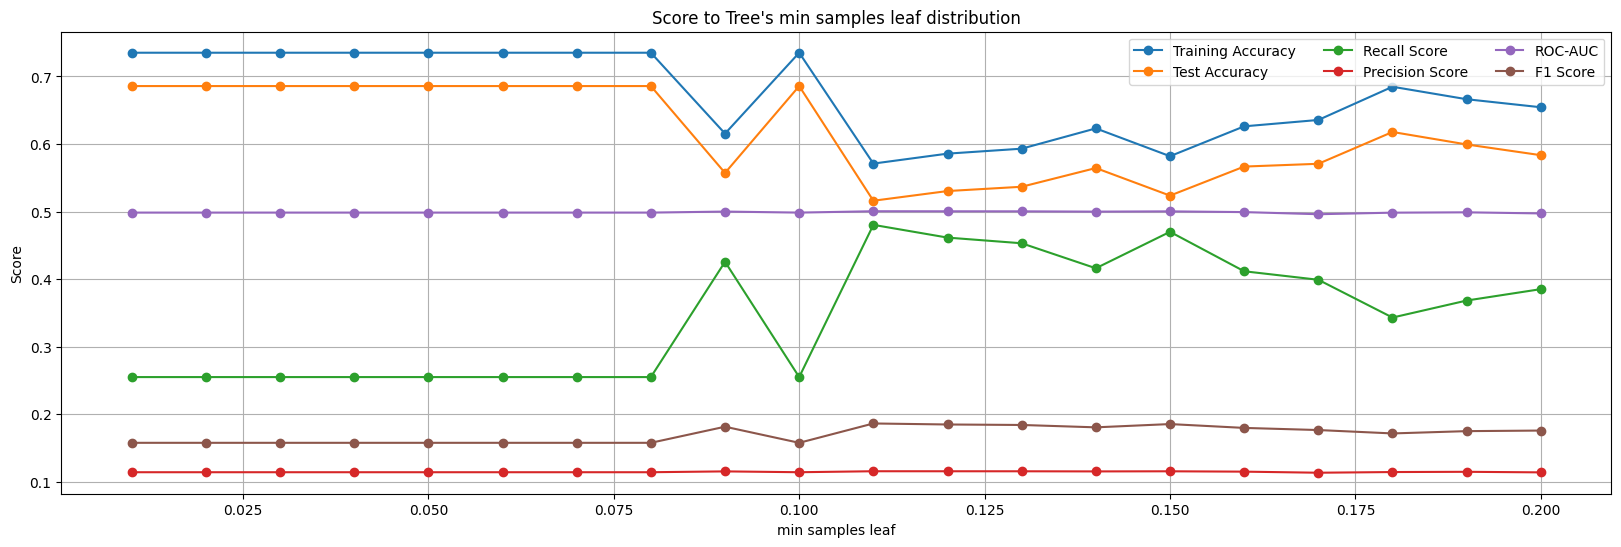

In [19]:
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"min_samples_leaf", np.arange(0.01,0.21,0.01))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>4. max_leaf_nodes</h4>    
    <ul>
        <li>Purpose: Limits the number of leaf nodes in the tree.</li>
        <li>Tip: It can be used as an alternative to max_depth to control complexity.</li>
    </ul>        
</div>

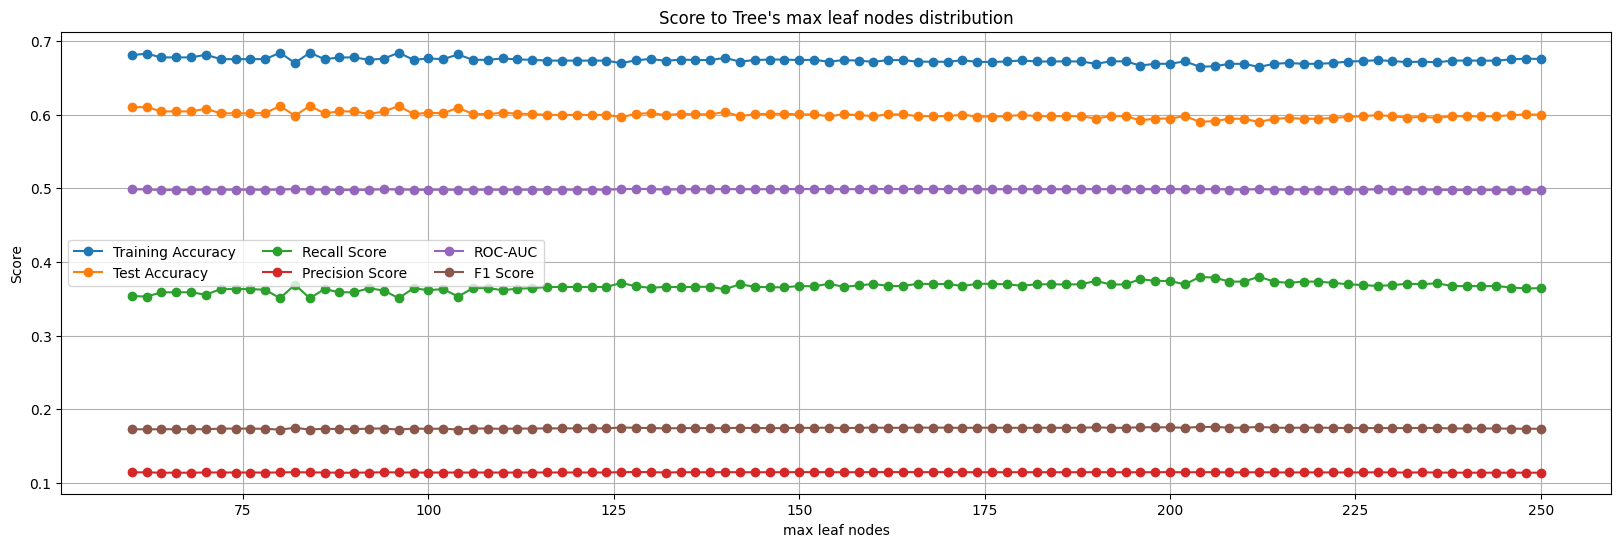

In [20]:
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"max_leaf_nodes", range(60,252,2))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>5. max_features</h4>    
    <ul>
        <li>Purpose: The number of features to consider when looking for the best split.</li>
    </ul>        
</div>

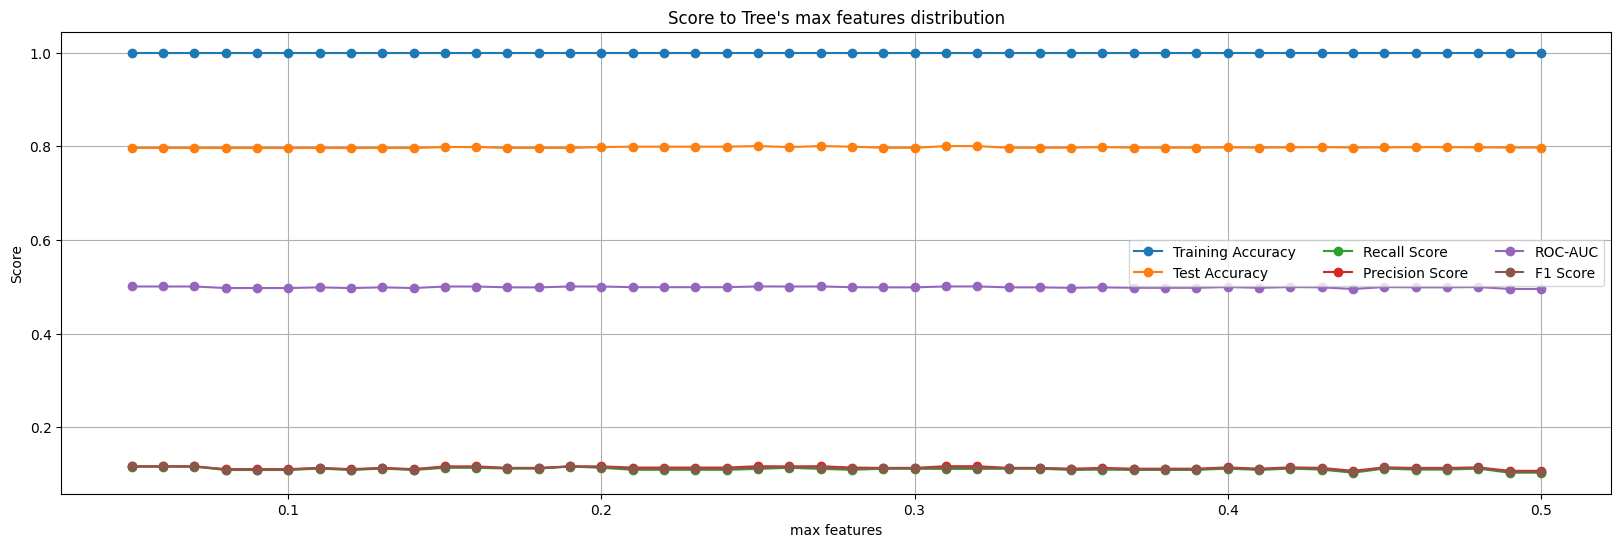

In [21]:
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"max_features", np.arange(0.05, 0.51, 0.01))

<div style="font-family: Calibri; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h4>6. min_impurity_decrease</h4>    
    <ul>
        <li>A node will be split if this split induces a decrease of the impurity greater than or equal to this value.</li>
    </ul>        
</div>

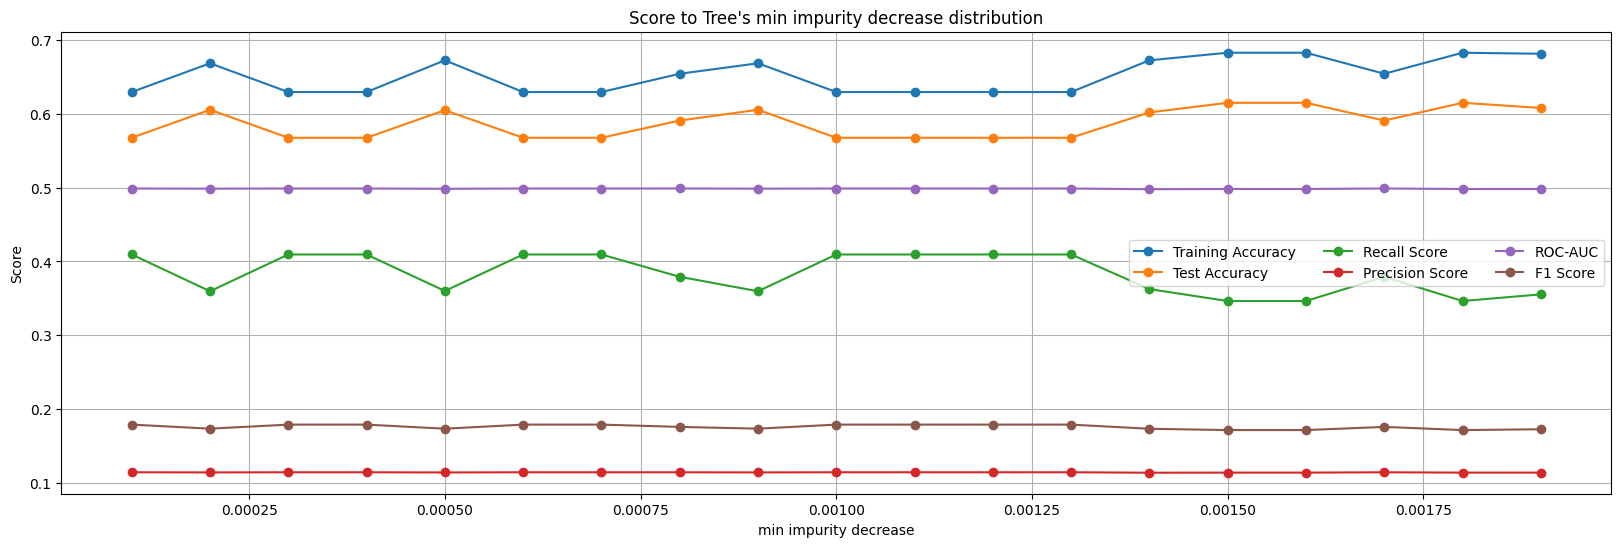

In [22]:
determine_parameter(X_train, y_train, X_test, y_test, DecisionTreeClassifier,"min_impurity_decrease", np.arange(0.0001,0.002,0.0001))

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Decision Tree's Parameter Analysis Conclusion</h3>  
    <ul>
        <li>min_samples_split &#x2705;</li>        
        <ul>
            <li>Recall score best range static is between 0.10 to 0.20</li>            
        </ul>
    </ul>        
    <ul>
        <li>min_samples_leaf &#x2705;</li>        
        <ul>
            <li>Recall score best range is stabilized at 0.15. Score went above 60%</li>            
        </ul>
    </ul>            
    <ul>
        <li>min_impurity_decrease &#x274C;</li>  
        <li>max_features &#x274C;</li>
        <li>max_leaf_nodes &#x274C;</li>
        <ul><li>The graph for these 3 features pretty much is flat line, indicating this parementer does not contribute enough to improve prediction</li></ul>
    </ul>        
    <ul>
        <li>max_depth  &#x2705;</li>        
        <ul>
            <li>The recall score is readually decreasing as depth increases</li>
            <li>Training and Test score were in upword trend, indicating accuracy getting better. But simultanelously Recall, and precision score are decreasing</li>
            </li>Peak is at aroung 11</li>
        </ul>
    </ul>        
</div>

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <h2>4. DecisionTree</h2>
    <font size=4>        
    <ul>
        <li>GridSearchCV</li>
        <li>Decision Tree using class weight</li>
    </ul>
    </font>
</div>

In [23]:
tree = DecisionTreeClassifier(random_state = 42, class_weight={0:1, 1:9})

In [24]:
param_grid = [
    {
        'min_samples_split': np.arange(0.10,0.2,0.01),
        'min_samples_leaf': np.arange(0.15,0.20,0.01)
    },
    {    
        'max_depth': range(10,20,1)
    },
    {
        'min_samples_split': np.arange(0.10,0.2,0.01)
    }
]

In [25]:
cv = GridSearchCV(tree, param_grid, cv=5, n_jobs=-1, verbose=True, scoring=make_scorer(fbeta_score, beta=3, pos_label=1));

In [26]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 9},
                                              random_state=42),
             n_jobs=-1,
             param_grid=[{'min_samples_leaf': array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                          'min_samples_split': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])},
                         {'max_depth': range(10, 20)},
                         {'min_samples_split': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])}],
             scoring=make_scorer(fbeta_score, response_method='predict', beta=3, pos_label=1),
             verbose=True)

In [27]:
print("Best Parameters:", cv.best_params_)
print("Best CV Score:", cv.best_score_)

Best Parameters: {'min_samples_split': 0.13999999999999999}
Best CV Score: 0.5763068836018563


In [28]:
model = cv.best_estimator_
model

DecisionTreeClassifier(class_weight={0: 1, 1: 9},
                       min_samples_split=0.13999999999999999, random_state=42)

In [29]:
y_pred = model.predict(X_test)

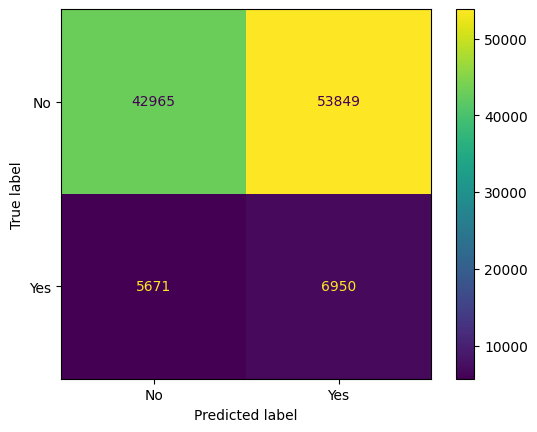

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', display_labels=["No","Yes"]);

In [31]:
rs = recall_score(y_test, y_pred, pos_label=1)
ps = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
ac = accuracy_score(y_test, y_pred)

In [32]:
print(f"{'Recall Score:':<20}{rs:<5}")
print(f"{'Precision Score:':<20}{ps:<5}")
print(f"{'F1 Score:':<20}{f1:<5}")
print(f"{'Accuracy Score:':<20}{ac:<5}")

Recall Score:       0.5506695190555424
Precision Score:    0.1143110906429382
F1 Score:           0.18932171070552983
Accuracy Score:     0.4561155023529949


In [33]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(model, X_train, y_train, X_test, y_test)

In [34]:
rs_list, ps_list, f1_list, ac_list = [],[],[],[]
for thresh in np.arange(0.3,0.8,0.1):
    rs, ps, f1, ac, y_test_pred = calc_scores(model, X_train, y_train, y_train_pred_prob, X_test, y_test, y_test_pred_prob, thresh)
    rs_list.append(rs) 
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)

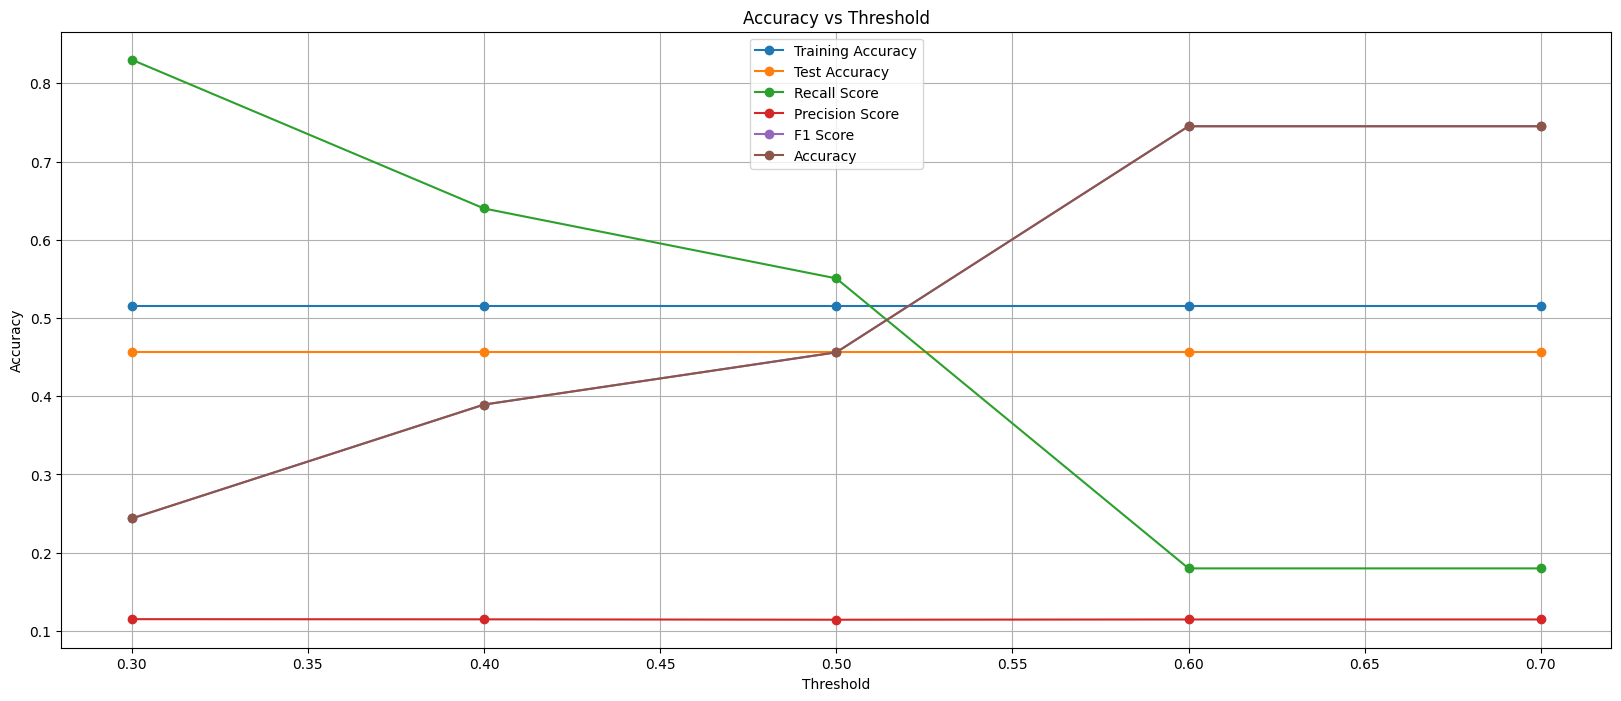

In [35]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0.3,0.8,0.1), rs_list, label='Recall Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ac_list, label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()